In [1]:
# pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [3]:
df=pd.read_excel('Gold_data.xlsx')
df.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [4]:
df.set_index('date',inplace=True)
df.head()

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2182 entries, 2016-01-01 to 2021-12-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2182 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [6]:
df.describe()

,price
count,2182.000000
mean,3284.450046
std,719.564434
min,2252.600000
25%,2697.020000
50%,2879.800000
75%,4147.325000
max,4966.300000


<AxesSubplot:xlabel='date'>

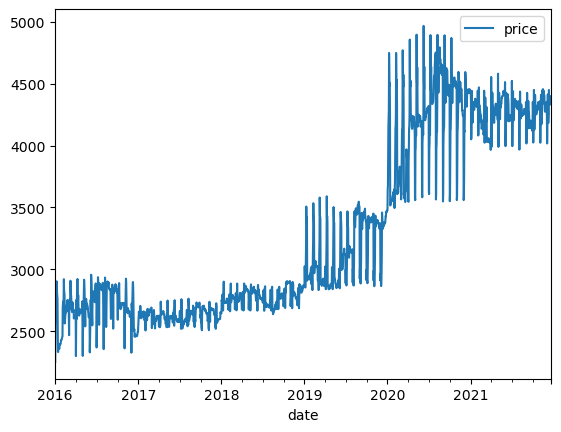

In [7]:
df.plot()

<AxesSubplot:xlabel='price', ylabel='Density'>

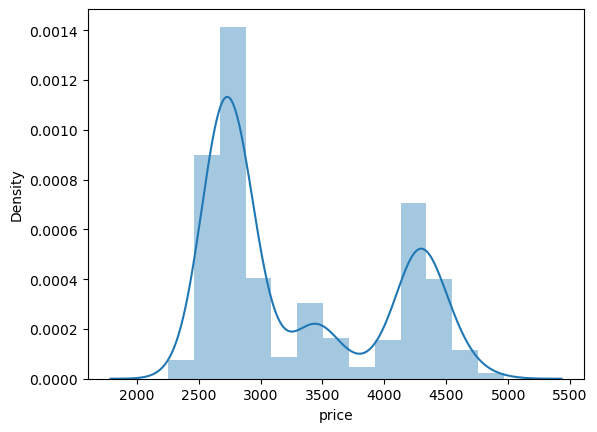

In [8]:
sns.distplot(df['price'])

In [9]:
# Augmented Dickey-Fuller Test:
result=adfuller (df['price'])
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))
        
p=result[1]

if p>0.05:
    print('the data set not stationary')
else:
    print('the data set is stationary')


Test Statistic: -0.309904
p-value: 0.924090
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
the data set not stationary


In [10]:
# convert the non- stationary to stationary data
df_log=np.log(df['price'])
df['price_diff']=df_log.diff()

In [11]:
df.isna().sum()

price         0
price_diff    1
dtype: int64

In [12]:
df.dropna(inplace=True)

In [13]:
# Augmented Dickey-Fuller Test:
result=adfuller (df['price_diff'])
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))
        
p=result[1]

if p>0.05:
    print('the data set not stationary')
else:
    print('the data set is stationary')


Test Statistic: -21.394232
p-value: 0.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
the data set is stationary


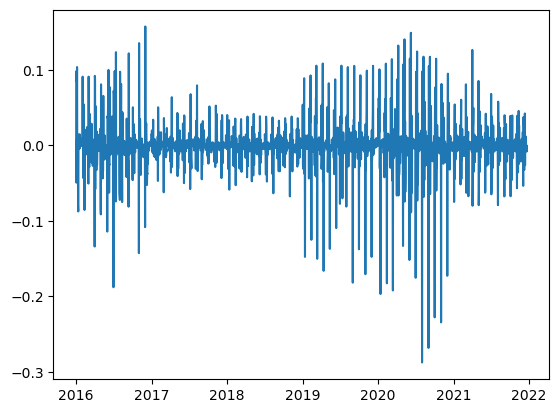

In [14]:
plt.plot(df['price_diff'])

# Forecasting on SARIMAX

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [ ]:
# fit auto_arima function to gold price datast
from pmdarima import auto_arima
stepwise_fit=auto_arima(df['price_diff'],start_p=1,start_q=1,
                       max_p=3,max_q=3,m=12,
                       start_P=0,seasonal=True,
                       d=None,D=1,trace=True,
                        error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=23.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-7252.754, Time=1.67 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-7702.421, Time=8.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=24.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-7254.754, Time=0.28 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-7252.395, Time=3.31 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-8010.765, Time=23.94 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=49.78 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=19.40 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-8010.643, Time=14.64 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-8030.199, Time=55.49 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-7729.747, Time=10.68 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=59.03 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=25.89 sec


In [ ]:
# split the data into test/train set
train=df.iloc[:len(df)-365]
test=df.iloc[len(df)-365:] # set one year(12 months) for testing

In [ ]:
#Fit a SARIMAX(2,0,0)x(2,1,0,12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['price'],order = (2, 0, 0), seasonal_order =(2, 1, 0, 12))
result = model.fit()
result.summary()

In [ ]:
# prediction of ARIMA model against the test set
start=len(train)
end=len(train)+len(test)-1

In [ ]:
# Predictions for one-year against the test set
predictions = result.predict(start, end, typ = 'levels').rename("Predictions")

In [ ]:
predictions

In [ ]:
# plot predictions and actual values
predictions.plot(legend = True)
test['price'].plot(legend = True)

In [ ]:
#Forecast using ARIMA Model
# Train the model on the full dataset
model = model = SARIMAX(df['price'], 
                        order = (2, 0, 0), 
                        seasonal_order =(2, 1, 0, 12))
result = model.fit()

In [ ]:
# Forecast for the next 30 days
forecast = result.predict(start = len(df), 
                          end = (len(df)-1) + 1 * 30, 
                          typ = 'levels').rename('Forecast 30 days')

In [ ]:
# Plot the forecast values
df['price'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [ ]:
# Load specific evaluation tools
from statsmodels.tools.eval_measures import rmse
rmse_sarimax=rmse(test["price"], predictions)

# Calculate root mean squared error
print('RMSE of the gold price:',rmse_sarimax)

# CROSS-VERIFYING

In [ ]:
# Split data into train / test sets
train1 = df.iloc[:len(df)-730]
test1 = df.iloc[len(df)-730:] # set two year(24 months) for testing

In [ ]:
# prediction of SARIMA model against the test set
start1=len(train1)
end1=len(train1)+len(test1)-1

In [ ]:
# Predictions for 2-year against the test set
predictions1 = result.predict(start1, end1, typ = 'levels').rename("Predictions1")

In [ ]:
# plot predictions and actual values
predictions1.plot(legend = True)
test['price'].plot(legend = True)

# prophet model

In [ ]:
# !pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dt=pd.read_excel('Gold_data.xlsx')

In [ ]:
dt['date'] = pd.to_datetime(dt ['date'])

In [ ]:
dt.columns = ['ds', 'y']
dt.head()

In [ ]:
# model develpment
p= Prophet(interval_width=0.80, daily_seasonality=True)
model = p.fit(dt)

In [ ]:
# genarete the next 30 day  dates
future = p.make_future_dataframe(periods=30, freq='D')
future.tail(30)

In [ ]:
# forecasting the next 30 days
forecast_prediction = p.predict(future)
forecast_prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

In [ ]:
# plot the forecasting gold price
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(p,forecast_prediction)

In [ ]:
# plot the model componets
plot_components_plotly(p, forecast_prediction)

In [ ]:
import math
#mean square error
MSE = np.square(np.subtract(dt['y'],forecast_prediction['yhat'])).mean() 
# root mean square
RMSE_prophet = math.sqrt(MSE)
print("Root Mean Square Error of gold price:\n")
print(RMSE_prophet)

# Darts librery

In [ ]:
# pip install darts

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries

In [ ]:
gold=pd.read_excel('Gold_data.xlsx')

In [ ]:
# convert the gold data set into the Timeseries
df_series=TimeSeries.from_dataframe(gold, 'date', 'price')

In [ ]:
df_series

In [ ]:
# Train and validation split
train_gold,val_gold=df_series[:-365],df_series[-365:]

# Forecasting NaiveSeasonal model

In [ ]:
from darts.models import NaiveSeasonal
from darts.utils.statistics import check_seasonality
from darts.metrics import rmse

In [ ]:
# check seasonality in train data
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_gold, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [ ]:
# NaiveSeasonal model
seasonal_model = NaiveSeasonal(K=8)
seasonal_model.fit(train_gold)

In [ ]:
pred_naive=seasonal_model.predict(n=len(val_gold)+30)
pred_naive.tail(30)

In [ ]:
plt.figure(figsize=(20,5))
df_series.plot(label='actual price')
pred_naive.plot(label='forecost next 30 days price')
plt.legend();

In [ ]:
rmse_naive=rmse(df_series, pred_naive)
print('RMSE of the gold price = {:.2f}%'.format(rmse_naive))

# Forecasting NBEATSModel

In [ ]:
from darts.models import NBEATSModel
model_nbeats=NBEATSModel(input_chunk_length=24,output_chunk_length=12,n_epochs=100,random_state=42)
model_nbeats.fit(train_gold,verbose=True)

In [ ]:
pred=model_nbeats.predict(n=365)

In [ ]:
forecast= model_nbeats.predict(n=30, series=val_gold)

In [ ]:
df_series.plot(label='actual')
forecast.plot(label='forecost next 30 day')
plt.legend()

In [ ]:
rmse_nbeats=rmse(df_series, pred)
print('RMSE of the gold price = {:.2f}%'.format(rmse_nbeats))

# xgboost forecasting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
dn = pd.read_excel('Gold_data.xlsx')
dn = dn.set_index('date')
dn.index = pd.to_datetime(dn.index)

In [ ]:
# create a time series features

def create_features(dn):
    """
    Create time series features based on time series index.
    """
    dn = dn.copy()
    dn['dayofweek'] = dn.index.dayofweek
    dn['quarter'] = dn.index.quarter
    dn['month'] = dn.index.month
    dn['year'] = dn.index.year
    dn['dayofyear'] = dn.index.dayofyear
    dn['dayofmonth'] = dn.index.day
    dn['weekofyear'] = dn.index.isocalendar().week
    return dn

dn = create_features(dn)

In [ ]:
# split the data

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# model fitting

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

In [ ]:
# model predictions
# plot the actual and forecating price

test['prediction'] = reg.predict(X_test)
dn = dn.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = dn[['price']].plot(figsize=(15, 5))
dn['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
rmse_xgboost = np.sqrt(mean_squared_error(test['price'], test['prediction']))
print(f'RMSE Score on Test set: {rmse_xgboost:0.2f}')

In [ ]:
# Compare the rmse of all forecasting models

data = {"MODEL":pd.Series(["SARIMAX","Prophet","Naive seasonal","NBEATS model",'xgboost forecasting']),
        "RMSE_Values":pd.Series([rmse_sarimax,RMSE_prophet,rmse_naive,rmse_nbeats,rmse_xgboost])}
table=pd.DataFrame(data)
table